<a href="https://colab.research.google.com/github/ernesmf23/ML-y-Analisis-de-Datos/blob/main/K_means_y_Clustering_NIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##K MEANS##

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Paso 1: Definir los datos
data = {
    'Muestra': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'x': [35, 37, 39, 41, 45, 48, 49, 44],
    'y': [18, 22, 25, 29, 47, 50, 52, 45]
}
df = pd.DataFrame(data)
X = df[['x', 'y']].values

# Paso 2: Centroides fijos (A=0, D=3, G=6)
centroid_indices = [0, 3, 6]
centroids = X[centroid_indices]

# Paso 3: Calcular distancias a cada centroide (A, D, G)
distances = cdist(X, centroids)
df['dist_A'] = distances[:, 0]
df['dist_D'] = distances[:, 1]
df['dist_G'] = distances[:, 2]

# Paso 4: Asignar cada punto al cluster del centroide más cercano
df['cluster'] = np.argmin(distances, axis=1)

# Paso 5: Calcular a(i), b(i), s(i) manualmente
def silhouette_manual(X, labels):
    n = len(X)
    silhouette_vals = []
    a_vals = []
    b_vals = []

    for i in range(n):
        xi = X[i]
        ci = labels[i]

        # a(i): distancia promedio al mismo cluster
        same_cluster = [j for j in range(n) if labels[j] == ci and j != i]
        if same_cluster:
            a_i = np.mean([np.linalg.norm(xi - X[j]) for j in same_cluster])
        else:
            a_i = 0

        # b(i): distancia promedio al cluster más cercano
        b_i = np.inf
        for cj in set(labels):
            if cj == ci:
                continue
            other_cluster = [j for j in range(n) if labels[j] == cj]
            if other_cluster:
                dist = np.mean([np.linalg.norm(xi - X[j]) for j in other_cluster])
                if dist < b_i:
                    b_i = dist

        # s(i)
        if max(a_i, b_i) == 0:
            s_i = 0
        else:
            s_i = (b_i - a_i) / max(a_i, b_i)

        a_vals.append(a_i)
        b_vals.append(b_i)
        silhouette_vals.append(s_i)

    return a_vals, b_vals, silhouette_vals

# Paso 6: Calcular
a_vals, b_vals, s_vals = silhouette_manual(X, df['cluster'].values)
df['a(i)'] = a_vals
df['b(i)'] = b_vals
df['s(i)'] = s_vals

# Paso 7: Mostrar resultados
cols = ['Muestra', 'x', 'y', 'dist_A', 'dist_D', 'dist_G', 'cluster', 'a(i)', 'b(i)', 's(i)']
print(df[cols].to_string(index=False))
print(f"\nCoeficiente promedio de Silhouette: {np.mean(s_vals):.4f}")


Muestra  x  y    dist_A    dist_D    dist_G  cluster     a(i)      b(i)     s(i)
      A 35 18  0.000000 12.529964 36.769553        0 4.472136 10.296111 0.565648
      B 37 22  4.472136  8.062258 32.310989        0 4.472136  5.833905 0.233423
      C 39 25  8.062258  4.472136 28.792360        1 4.472136  5.833905 0.233423
      D 41 29 12.529964  0.000000 24.351591        1 4.472136 10.296111 0.565648
      E 45 47 30.675723 18.439089  6.403124        2 4.293944 20.621299 0.791771
      F 48 50 34.539832 22.135944  2.236068        2 4.293944 24.353302 0.823681
      G 49 52 36.769553 24.351591  0.000000        2 5.747172 26.571976 0.783713
      H 44 45 28.460499 16.278821  8.602325        2 5.747172 18.447174 0.688452

Coeficiente promedio de Silhouette: 0.5857


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples, pairwise_distances

# Datos de las muestras
data = {
    'Muestra': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'x': [35, 37, 39, 41, 45, 48, 49, 44],
    'y': [18, 22, 25, 29, 47, 50, 52, 45]
}
df = pd.DataFrame(data)

# Centroides predefinidos (tomamos A, D y G como centroides)
centroids = {
    0: np.array([35, 18]),  # A
    1: np.array([41, 29]),  # D
    2: np.array([49, 52])   # G
}

# Asignar clusters manualmente según el centroide más cercano
def assign_cluster(row):
    distances = {k: np.linalg.norm(row[['x', 'y']].values - v) for k, v in centroids.items()}
    return min(distances, key=distances.get)

df['cluster'] = df.apply(assign_cluster, axis=1)

# Calcular matriz de distancias entre todos los puntos
coords = df[['x', 'y']].values
distance_matrix = pairwise_distances(coords, metric='euclidean')

# Mostrar matriz de distancias
print("📏 Matriz de distancias euclidianas entre puntos:\n")
dist_df = pd.DataFrame(distance_matrix, index=df['Muestra'], columns=df['Muestra'])
print(dist_df.round(6))

# Calcular a(i), b(i), s(i)
a_i = []
b_i = []
s_i = []

for i in range(len(df)):
    own_cluster = df.loc[i, 'cluster']
    own_indices = df[df['cluster'] == own_cluster].index.tolist()
    own_indices.remove(i)

    # a(i): distancia promedio a los puntos del mismo cluster
    if own_indices:
        a = np.mean([distance_matrix[i][j] for j in own_indices])
    else:
        a = 0  # si está solo en el cluster
    a_i.append(a)

    # b(i): distancia promedio al cluster más cercano
    other_clusters = [c for c in df['cluster'].unique() if c != own_cluster]
    b_vals = []
    for oc in other_clusters:
        oc_indices = df[df['cluster'] == oc].index.tolist()
        b = np.mean([distance_matrix[i][j] for j in oc_indices])
        b_vals.append(b)
    b = min(b_vals)
    b_i.append(b)

    # s(i)
    s = (b - a) / max(a, b) if max(a, b) > 0 else 0
    s_i.append(s)

df['a(i)'] = a_i
df['b(i)'] = b_i
df['s(i)'] = s_i

# Mostrar tabla con resultados
print("\n📊 Tabla con a(i), b(i), s(i):\n")
print(df[['Muestra', 'x', 'y', 'cluster', 'a(i)', 'b(i)', 's(i)']].round(6))


📏 Matriz de distancias euclidianas entre puntos:

Muestra          A          B          C          D          E          F  \
Muestra                                                                     
A         0.000000   4.472136   8.062258  12.529964  30.675723  34.539832   
B         4.472136   0.000000   3.605551   8.062258  26.248809  30.083218   
C         8.062258   3.605551   0.000000   4.472136  22.803509  26.570661   
D        12.529964   8.062258   4.472136   0.000000  18.439089  22.135944   
E        30.675723  26.248809  22.803509  18.439089   0.000000   4.242641   
F        34.539832  30.083218  26.570661  22.135944   4.242641   0.000000   
G        36.769553  32.310989  28.792360  24.351591   6.403124   2.236068   
H        28.460499  24.041631  20.615528  16.278821   2.236068   6.403124   

Muestra          G          H  
Muestra                        
A        36.769553  28.460499  
B        32.310989  24.041631  
C        28.792360  20.615528  
D        24.351591 

In [ ]:
import numpy as np

# Datos
X = np.array([
    [35, 18],
    [37, 22],
    [39, 25],
    [41, 29],
    [45, 47],
    [48, 50],
    [49, 52],
    [44, 45]
])

# Asignación manual a clusters (basado en centroides A, D, G)
labels = np.array([0, 0, 1, 1, 2, 2, 2, 2])

k = len(np.unique(labels))
N = X.shape[0]

# Calcular centroides de cada cluster
centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

# Centroide general
overall_centroid = X.mean(axis=0)

# SSB (Between-cluster sum of squares)
SSB = 0
for i in range(k):
    ni = np.sum(labels == i)
    dist = np.linalg.norm(centroids[i] - overall_centroid)
    SSB += ni * dist**2

# SSW (Within-cluster sum of squares)
SSW = 0
for i in range(k):
    cluster_points = X[labels == i]
    dist = np.linalg.norm(cluster_points - centroids[i], axis=1)
    SSW += np.sum(dist**2)

# Cálculo del pseudo-F
pseudo_F = (SSB / (k - 1)) / (SSW / (N - k))

print(f"SSB (Between-cluster variance): {SSB:.4f}")
print(f"SSW (Within-cluster variance): {SSW:.4f}")
print(f"Pseudo-F statistic: {pseudo_F:.4f}")


SSB (Between-cluster variance): 1459.5000
SSW (Within-cluster variance): 66.0000
Pseudo-F statistic: 55.2841


##CLUSTERING JERARQUICO##

In [ ]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Datos
data = {
    "Muestra": ["A", "B", "C", "D", "E", "F", "G", "H"],
    "x": [35, 37, 39, 41, 45, 48, 49, 44],
    "y": [18, 22, 25, 29, 47, 50, 52, 45]
}
df = pd.DataFrame(data)
X = df[["x", "y"]].values


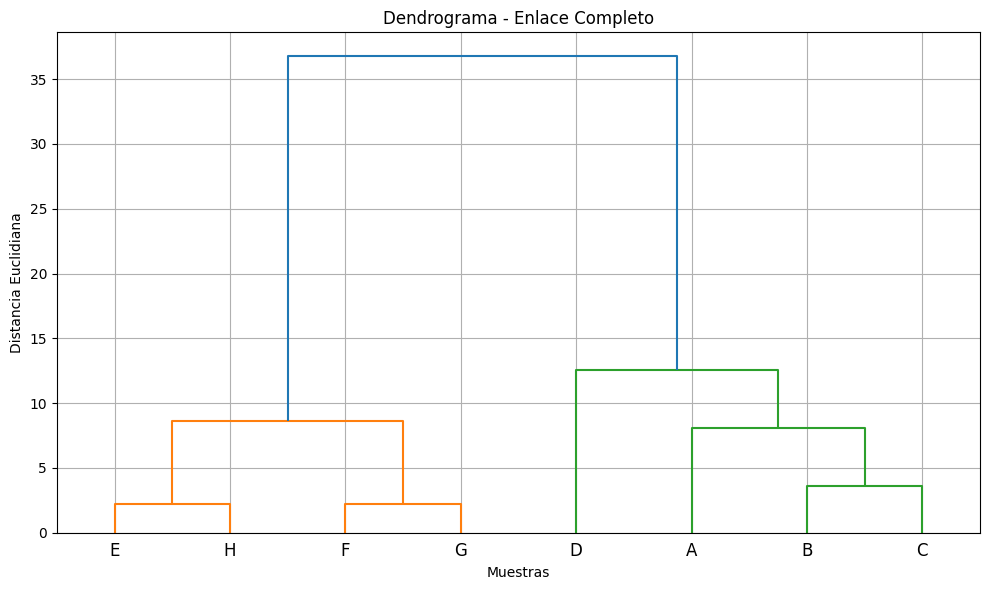

In [ ]:
# Calcular la matriz de distancias
dist_matrix = pdist(X, metric="euclidean")

# Clustering jerárquico con enlace completo
linked = sch.linkage(dist_matrix, method='complete')

# Mostrar el dendrograma
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(linked, labels=df["Muestra"].values, leaf_rotation=0)
plt.title("Dendrograma - Enlace Completo")
plt.xlabel("Muestras")
plt.ylabel("Distancia Euclidiana")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_samples, silhouette_score

# Datos
data = pd.DataFrame({
    'Muestra': list('ABCDEFGH'),
    'x': [35, 37, 39, 41, 45, 48, 49, 44],
    'y': [18, 22, 25, 29, 47, 50, 52, 45]
})

# Matriz de características
X = data[['x', 'y']].values

# 1. Clustering jerárquico (enlace completo)
Z = linkage(X, method='complete')
clusters = fcluster(Z, 3, criterion='maxclust')
data['Cluster'] = clusters

# 2. Calcular a(i), b(i), s(i)
def compute_silhouette_details(X, labels):
    n = X.shape[0]
    a = np.zeros(n)
    b = np.zeros(n)
    s = np.zeros(n)

    for i in range(n):
        same_cluster = [j for j in range(n) if labels[j] == labels[i] and j != i]
        other_clusters = [j for j in range(n) if labels[j] != labels[i]]

        if same_cluster:
            a[i] = np.mean([euclidean(X[i], X[j]) for j in same_cluster])
        else:
            a[i] = 0

        b_vals = []
        unique_labels = set(labels)
        unique_labels.remove(labels[i])
        for l in unique_labels:
            other_points = [j for j in range(n) if labels[j] == l]
            b_vals.append(np.mean([euclidean(X[i], X[j]) for j in other_points]))
        b[i] = min(b_vals)

        if max(a[i], b[i]) != 0:
            s[i] = (b[i] - a[i]) / max(a[i], b[i])
        else:
            s[i] = 0

    return a, b, s

a_vals, b_vals, s_vals = compute_silhouette_details(X, clusters)
data['a(i)'] = np.round(a_vals, 6)
data['b(i)'] = np.round(b_vals, 6)
data['s(i)'] = np.round(s_vals, 6)

# 3. Silhouette promedio
silhouette_avg = np.mean(s_vals)

# 4. Cálculo de SSH (intra) y SSB (entre)
k = len(np.unique(clusters))
centroides = np.array([X[clusters == c].mean(axis=0) for c in range(1, k + 1)])
global_centroid = np.mean(X, axis=0)

# SSH (SSW)
SSH = sum([np.sum((X[clusters == c + 1] - centroides[c])**2) for c in range(k)])

# SSB
n_c = [np.sum(clusters == (c + 1)) for c in range(k)]
SSB = sum([n_c[c] * np.sum((centroides[c] - global_centroid)**2) for c in range(k)])

# Pseudo-F
pseudo_F = (SSB / (k - 1)) / (SSH / (len(X) - k))

# Imprimir resultados
print("\n--- RESULTADOS ---")
print(data)
print(f"\nSilhouette promedio: {silhouette_avg:.6f}")
print(f"SSH (SSW): {SSH:.4f}")
print(f"SSB: {SSB:.4f}")
print(f"Pseudo-F: {pseudo_F:.4f}")



--- RESULTADOS ---
  Muestra   x   y  Cluster      a(i)       b(i)      s(i)
0       A  35  18        2  6.267197  12.529964  0.499823
1       B  37  22        2  4.038844   8.062258  0.499043
2       C  39  25        2  5.833905   4.472136 -0.233423
3       D  41  29        3  0.000000   8.354786  1.000000
4       E  45  47        1  4.293944  18.439089  0.767128
5       F  48  50        1  4.293944  22.135944  0.806019
6       G  49  52        1  5.747172  24.351591  0.763992
7       H  44  45        1  5.747172  16.278821  0.646954

Silhouette promedio: 0.593692
SSH (SSW): 78.6667
SSB: 1446.8333
Pseudo-F: 45.9799


##CLUSTERING NIR Y METODO K-MEANS##

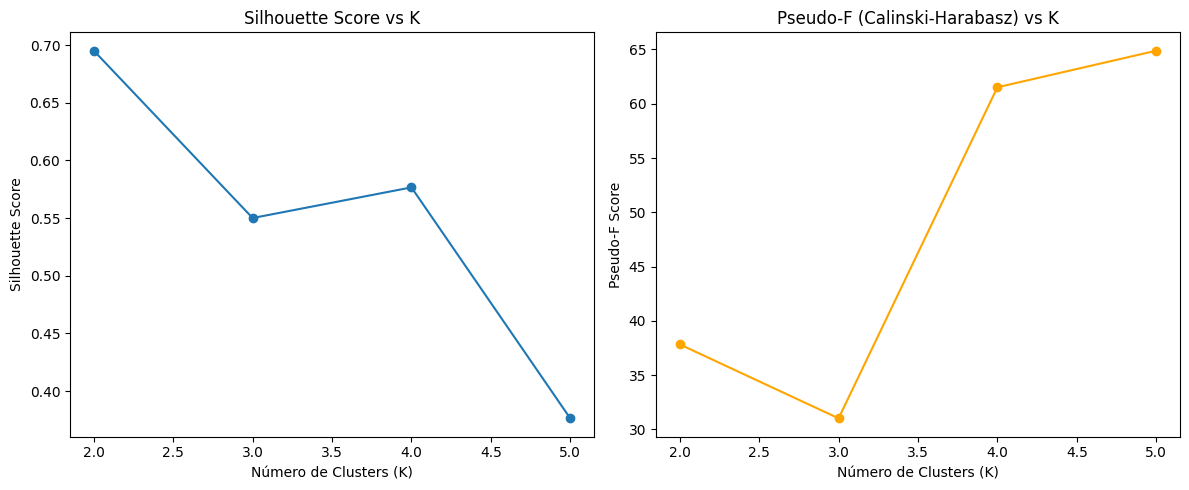

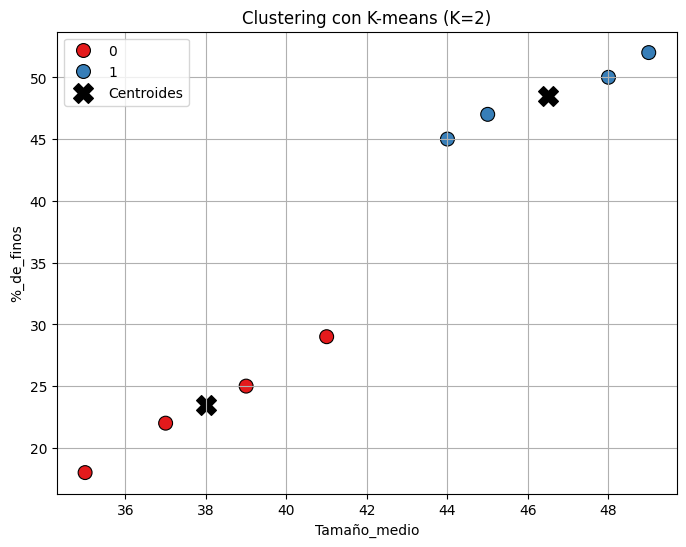

=== Resultados ===
  Muestra  Tamaño_medio  %_de_finos  Cluster
0       A            35          18        0
1       B            37          22        0
2       C            39          25        0
3       D            41          29        0
4       E            45          47        1
5       F            48          50        1
6       G            49          52        1
7       H            44          45        1

Silhouette Score: 0.6951
Pseudo-F Score: 37.8281


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Datos
datos = pd.DataFrame({
    "Muestra": list("ABCDEFGH"),
    "Tamaño_medio": [35, 37, 39, 41, 45, 48, 49, 44],
    "%_de_finos": [18, 22, 25, 29, 47, 50, 52, 45]
})

# 2. Preprocesamiento: escalamiento
X = datos[["Tamaño_medio", "%_de_finos"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Evaluar diferentes valores de k
silhouette_scores = []
pseudo_f_scores = []
K_range = range(2, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    pseudo_f_scores.append(calinski_harabasz_score(X_scaled, labels))

# 4. Visualizar métricas para determinar K óptimo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")

plt.subplot(1, 2, 2)
plt.plot(K_range, pseudo_f_scores, marker='o', color='orange')
plt.title("Pseudo-F (Calinski-Harabasz) vs K")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Pseudo-F Score")

plt.tight_layout()
plt.show()

# 5. Aplicar K-means con K=2 (según mejor silhouette)
k_opt = 2
kmeans_final = KMeans(n_clusters=k_opt, n_init=10, random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

datos["Cluster"] = clusters

# 6. Visualización final de clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="Tamaño_medio", y="%_de_finos", hue="Cluster", data=datos,
    palette="Set1", s=100, edgecolor="black"
)
centers = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centroides')
plt.title("Clustering con K-means (K=2)")
plt.legend()
plt.grid(True)
plt.show()

# 7. Mostrar resultados
print("=== Resultados ===")
print(datos)
print(f"\nSilhouette Score: {silhouette_score(X_scaled, clusters):.4f}")
print(f"Pseudo-F Score: {calinski_harabasz_score(X_scaled, clusters):.4f}")
